In [ ]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [19]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [27]:
schedules = []

In [28]:
# standard way
circuit = q.QuantumCircuit(2)
circuit.x(0)
circuit.cx(0, 1)
circuit.x(0)

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration

schedules.append(schedule)

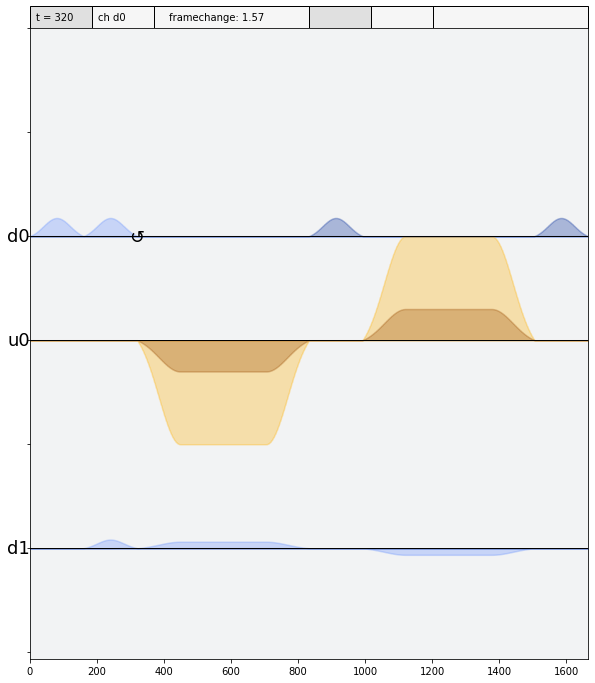

In [29]:
schedules[0].draw(channels=[config.drive(0), config.control(0), config.drive(1)])

In [30]:
# cross-gate pulse cancellation way
circuit = q.QuantumCircuit(2)
circuit.open_cx(0, 1)

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration

schedules.append(schedule)

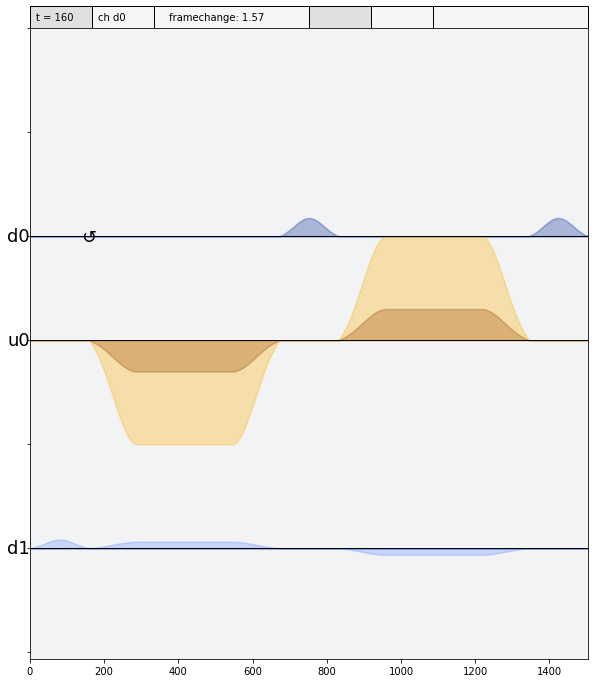

In [32]:
schedules[1].draw(channels=[config.drive(0), config.control(0), config.drive(1)])

In [9]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5dd6e050c02fc60018634890


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [11]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
result = job.result()

In [13]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [14]:
counts_list = []
counts = marginal_counts(result.get_counts(0), meas_qubits=[0,1])    
counts_list.append(counts)
print('Standard way: %s' % counts)

counts = marginal_counts(result.get_counts(1), meas_qubits=[0,1])    
counts_list.append(counts)
print('Our cross-gate pulse cancellation way: %s' % counts)

Standard way: {'00': 740, '01': 192, '10': 6968, '11': 100}
Our cross-gate pulse cancellation way: {'00': 759, '01': 164, '10': 6984, '11': 93}


In [15]:
print(counts_list)

[{'00': 740, '01': 192, '10': 6968, '11': 100}, {'00': 759, '01': 164, '10': 6984, '11': 93}]


/Users/alijavadi/Desktop/ajavadia-terra/qiskit/visualization/counts_visualization.py:187: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


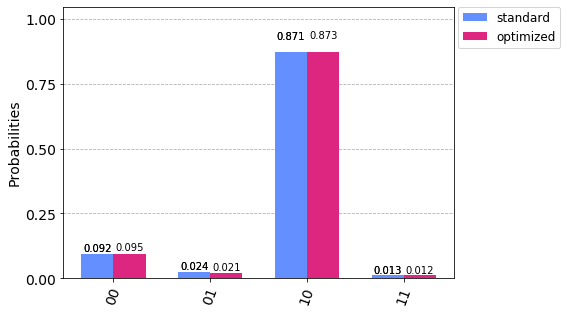

In [16]:
from qiskit.visualization import plot_histogram
plot_histogram(counts_list, legend=['standard', 'optimized'])